# Natural Language Processing for the Fake News Challenge

## Main Imports

In [2]:
import torch
import string
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

import nltk
nltk.download('stopwords')
nltk.download('punkt')

from sklearn.base import TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc, f1_score

from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional

!pip install transformers
import transformers

Mounted at /content/drive
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
     |████████████████████████████████| 2.3MB 8.4MB/s 
     |████████████████████████████████| 3.3MB 39.4MB/s 
     |████████████████████████████████| 901kB 44.2MB/s 


## Set up the data for preprocessing
### Load the data

In [3]:
main_path = '/content/drive/My Drive/University Work/Year 4/Natural Language Processing/'
data_folder_name = 'data'
train_body_filename = 'train_bodies.csv'
train_stance_filename = 'train_stances.csv'

train_body_path = main_path + data_folder_name +'/'+ train_body_filename 
train_stance_path = main_path + data_folder_name + '/' + train_stance_filename

body_data = pd.read_csv(train_body_path)
stance_data = pd.read_csv(train_stance_path)

### Preprocessing by removing stopwords and punctuation and applying stemming

In [4]:
def preprocess(text):

    text = nltk.tokenize.word_tokenize(text)
    text = [word for word in text if word not in nltk.corpus.stopwords.words('english')]
    text = (" ").join(text)

    table = str.maketrans('', '', string.punctuation)
    text = text.translate(table)

    ps = nltk.stem.PorterStemmer()
    text = nltk.tokenize.word_tokenize(text)

    text = [ps.stem(word) for word in text]
    text = (" ").join(text)

    return text

In [5]:
body_data['articleBody'] = body_data['articleBody'].apply(lambda x: preprocess(x))
stance_data['Headline'] = stance_data['Headline'].apply(lambda x: preprocess(x))

### Merge the data based on the Body ID to get one dataframe containing the corresponding Headlines and Article Bodies

In [6]:
total_data = pd.merge(body_data, stance_data, on='Body ID')

# add relevance column
total_data['Relevance'] = np.where(total_data['Stance'] == 'unrelated', 0, 1)
total_data.sample(10)

,Body ID,articleBody,Headline,Stance,Relevance
21607,1267,beirut — lebanon ’ militari detain wife child ...,isi chlorin attack secur forc confirm – iraq o...,unrelated,0
19106,1131,ye ve known christian bale might next actor po...,govern fire employe skip work 24 year,unrelated,0
7888,503,warn graphic content A man blame small peni gi...,jihadi john name moham emwazi west london,unrelated,0
27965,1569,michael zehafbibeau name suspect shooter possi...,canada probe michael zehafbibeau possibl suspe...,discuss,1
45811,2347,A uniform soldier shot canadian war memori wed...,break soldier shot war memori ottawa,agree,1
9901,611,ottawa – the man report shot assail parliament...,how canadian sergeantatarm kevin vicker kill s...,discuss,1
18664,1103,when parent think school trip envis form educ ...,chees addict break kim jongun s ankl,unrelated,0
20277,1210,call newton ’ third law appl analyst for everi...,kim jongun s sister take control north korea,unrelated,0
34477,1877,A woman detain lebanes author wife islam state...,iraq say arrest woman Is not the wife isi lead...,agree,1
30714,1709,A man accus tri rape teenag girl india critic ...,No A spider did not burrow under A man s skin ...,unrelated,0


### Splitting the dataset into train and validation sets

In [7]:
input_columns = total_data[['Headline', 'articleBody']]
target = 'Relevance'
X_train, X_val, y_train, y_val = train_test_split(input_columns, total_data[target].values, test_size=0.20, random_state=0)

# check the size of our datasets
print('Size of training set:', X_train.shape)
print('Size of validation set:', X_val.shape)

X_train.sample(10)

Size of training set: (39977, 2)
Size of validation set: (9995, 2)


,Headline,articleBody
10792,audio gunfir michael brown case authent app co...,thi moment sleazi truth husband ’ cheat way ex...
33017,report isi fighter contract ebola incorrect sa...,By isaac abrak abuja nov 1 reuter A man claim ...
21397,eyecatch rare sight anna wintour without trade...,the pentagon confirm ahm abdi godan leader isl...
35035,oscar winner christian bale play steve job upc...,A polic search underway man slap peopl sneez p...
26129,woman stay In kfc for A week To get over her b...,An iraqi airstrik thursday septemb 4th kill ab...
41239,see crater meteorit made nicaragua,expert know whether meteorit disintegr impact ...
38435,russian TV actor wake find testicl stolen,A marri TV actor met young woman kiss sauna wo...
44181,islam state report youngest jihadist martyr battl,the copper box entomb state capitol 1795 someo...
38272,shot heard In alleg brown shoot record audio,while laptop sale continu drop appl s macbook ...
48543,advisoryislamist rebel leader kill US strike s...,while ’ clear exactli waterproof appl watch pe...


## TF-IDF Feature Extraction
### Custom Transformer for Pipeline

In [8]:
# custom transformer for column extraction
class ColumnExtractor(TransformerMixin):

    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

### Pipelines and Feature Union of Headline and Article Body
- Apply fit transform

In [9]:
max_features = 200

# create pipes and perform TF-IDF on Headline and Body columns
headline_pipe = make_pipeline(
    ColumnExtractor('Headline'),
    TfidfVectorizer(decode_error='ignore', min_df=4, max_df=0.5, max_features=max_features, lowercase=True)
)

body_pipe = make_pipeline(
    ColumnExtractor('articleBody'),
    TfidfVectorizer(decode_error='ignore', min_df=4, max_df=0.5, max_features=max_features, lowercase=True)
)

# combine headline and body transformers with a feature union and weight equally
preprocessor = FeatureUnion(transformer_list=[('headline', headline_pipe),
                                              ('body', body_pipe)],
                            transformer_weights= {
                                    'headline': 0.5,
                                    'body': 0.5
                               }
                           )

# fit transform and print data
tfidf_train = preprocessor.fit_transform(X_train).todense()
tfidf_val = preprocessor.transform(X_val).todense()
print('Train size: ', tfidf_train.shape)
print('Val size: ', tfidf_val.shape)

Train size:  (39977, 400)
Val size:  (9995, 400)


## Evaluation Metrics

### Confusion Matrix

In [11]:
# Create the confusion matrix
def plot_confusion_matrix(y_test, y_pred):
    ''' Plot the confusion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)

    # Create a dataframe with the confusion matrix values
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))

    # Plot the confusion matrix
    sn.set(font_scale=1.4) #for label size
    sn.heatmap(df_cm, annot=True,fmt='.0f',cmap="YlGnBu",annot_kws={"size": 10})# font size
    plt.show()

### ROC Curve

In [12]:
# ROC Curve
# Calculate the points in the ROC curve
def plot_roc_curve(y_test, y_pred):
    ''' Plot the ROC curve for the target labels and predictions'''
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc= auc(fpr,tpr)
    plt.figure(figsize=(12, 12))
    ax = plt.subplot(121)
    ax.set_aspect(1)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### Display Classification Accuracies over results and plot Confusion Matrix and ROC Curve results

In [13]:
def display_results(y_pred, y_val):

    # print classification report and plot confusion matrix and ROC curve
    print(classification_report(y_val, y_pred))
    plot_confusion_matrix(y_val, y_pred)
    plot_roc_curve(y_val, y_pred)

## Machine Learning Models

### Train Random Forest (RF) Classifier using TF-IDF Features and display results

In [ ]:
tfidf_RF_model = RandomForestClassifier(random_state=0).fit(tfidf_train, y_train)
tfidf_RF_model.score(tfidf_val, y_val)

0.9651825912956479

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      7228
           1       0.96      0.91      0.94      2767

    accuracy                           0.97      9995
   macro avg       0.96      0.95      0.96      9995
weighted avg       0.97      0.97      0.96      9995



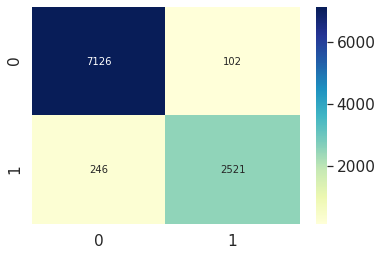

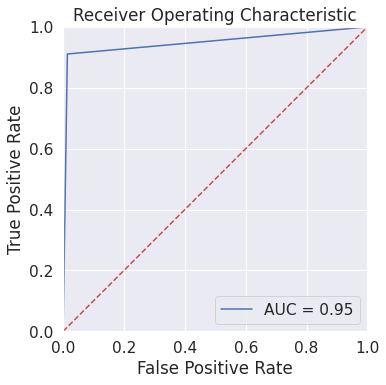

In [ ]:
y_pred = tfidf_RF_model.predict(tfidf_val)
display_results(y_pred, y_val)

# Tokenisation with BERT

### Load the model and tokeniser

In [ ]:
model_class, tokenizer_class, pretrained_weights = (transformers.DistilBertModel,
                                                    transformers.DistilBertTokenizer,
                                                    'distilbert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
bert_model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Embedding Retrieval

In [ ]:
def get_bert_embeddings(bert_model, data, batch_size):

    # set device and lambda function for classification token retrieval
    device = torch.device("cuda")
    get_cls_token_embeddings = lambda x: x[0][:, 0, :].squeeze()
    bert_embeddings = []  # initialise embeddings

    for i in range(batch_size, data.shape[0] + batch_size, batch_size):
    
        if i % 100 == 0:
            print("Batch", i)

        # tokenise
        tokenized = tokenizer(list(data['Headline'][i - batch_size:i]), list(data['articleBody'][i - batch_size:i]),\
                          padding='max_length', truncation=True, return_tensors="pt")
        
        # get input ids and set to device
        tokenized_text = tokenized['input_ids']
        tokenized_text = tokenized_text.to(device)

        # calculate embeddings and retrieve cls token embedding
        with torch.no_grad():
            word_embeddings = bert_model(tokenized_text)
        cls_token_embeddings = get_cls_token_embeddings(word_embeddings)

        # append to total embeddings
        if bert_embeddings == []:
            bert_embeddings = cls_token_embeddings
        else:
            bert_embeddings = torch.cat((bert_embeddings, cls_token_embeddings), 0)

        # clear cache and GPU memory
        del word_embeddings
        torch.cuda.empty_cache()

    return bert_embeddings

In [ ]:
device = torch.device("cuda")
bert_model = bert_model.to(device)
batch_size = 256

print("Training Set")
bert_train = get_bert_embeddings(bert_model, X_train, batch_size)
torch.save(bert_train, main_path + 'bert_train.pt')

print("Testing Set")
bert_val = get_bert_embeddings(bert_model, X_val, batch_size)
torch.save(bert_val, main_path + 'bert_val.pt')

Training Set
Batch 6400
Batch 12800
Batch 19200
Batch 25600
Batch 32000
Batch 38400
Testing Set
Batch 6400


In [20]:
# load, detach from GPU, and convert to numpy arrays
bert_train = torch.load(main_path + 'bert_train.pt').detach().cpu().numpy()
bert_val = torch.load(main_path + 'bert_val.pt').detach().cpu().numpy()

### Train Random Forest (RF) Classifier using BERT Embeddings and display results

In [ ]:
bert_RF_model = RandomForestClassifier(random_state=0).fit(bert_train, y_train)
bert_RF_model.score(bert_val, y_val)

0.8963481740870435

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      7228
           1       0.93      0.68      0.78      2767

    accuracy                           0.90      9995
   macro avg       0.91      0.83      0.86      9995
weighted avg       0.90      0.90      0.89      9995



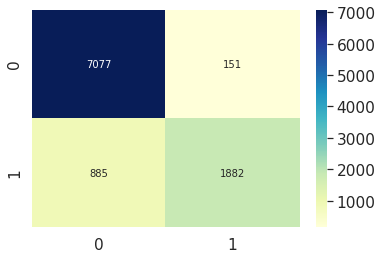

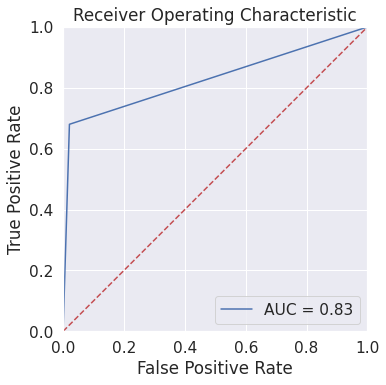

In [ ]:
y_pred = bert_RF_model.predict(bert_val)
display_results(y_pred, y_val)

## Deep Learning Models

### Train a Multi-Layer Perceptron (MLP) on TF-IDF Embeddings

#### Define the MLP

In [ ]:
tfidf_MLP = Sequential()
tfidf_MLP.add(Dense(64, activation='relu', input_dim=400))
tfidf_MLP.add(Dense(64, activation='relu'))
tfidf_MLP.add(Dense(1, activation='sigmoid'))
tfidf_MLP.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])
print(tfidf_MLP.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 64)                25664     
_________________________________________________________________
dense_22 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 65        
Total params: 29,889
Trainable params: 29,889
Non-trainable params: 0
_________________________________________________________________
None


#### Train the MLP

In [ ]:
batch_size = 32
tfidf_MLP.fit(tfidf_train, y_train, batch_size=batch_size,
        epochs=5, validation_data=(tfidf_val, y_val),
        steps_per_epoch=tfidf_train.shape[0]/batch_size)

Epoch 1/5
1249/1249 [==============================] - 3s 2ms/step - loss: 0.0229 - accuracy: 0.9919 - val_loss: 0.0743 - val_accuracy: 0.9755
Epoch 2/5
1249/1249 [==============================] - 3s 2ms/step - loss: 0.0194 - accuracy: 0.9933 - val_loss: 0.0828 - val_accuracy: 0.9749
Epoch 3/5
1249/1249 [==============================] - 3s 2ms/step - loss: 0.0174 - accuracy: 0.9936 - val_loss: 0.0766 - val_accuracy: 0.9752
Epoch 4/5
1249/1249 [==============================] - 3s 2ms/step - loss: 0.0150 - accuracy: 0.9948 - val_loss: 0.0842 - val_accuracy: 0.9749
Epoch 5/5
1249/1249 [==============================] - 3s 2ms/step - loss: 0.0126 - accuracy: 0.9951 - val_loss: 0.0873 - val_accuracy: 0.9742


### Display Results of MLP on Related/Unrelated Classification

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      7228
           1       0.97      0.94      0.95      2767

    accuracy                           0.97      9995
   macro avg       0.97      0.96      0.97      9995
weighted avg       0.97      0.97      0.97      9995



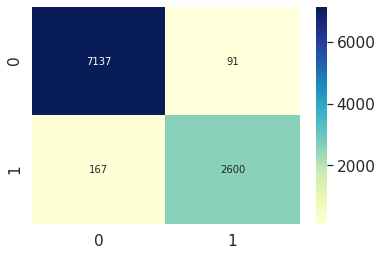

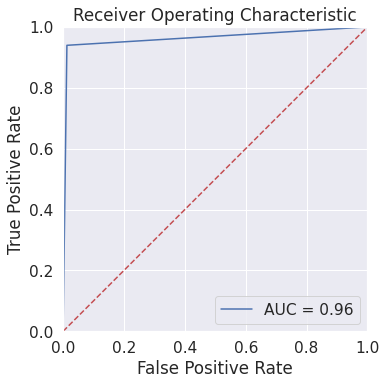

In [ ]:
y_pred = (tfidf_MLP.predict(tfidf_val) > 0.5).astype("int32")
display_results(y_pred, y_val)

### Train a Long Short Term Memory (LSTM) model on BERT Embeddings

In [21]:
# https://stackoverflow.com/questions/62281260/how-to-use-cnn-and-lstm-for-nlp-with-bert-embeddings
from keras.layers import LeakyReLU

reshaped_bert_train = bert_train.reshape(-1, 768, 1)
reshaped_bert_val = bert_val.reshape(-1, 768, 1)

bert_LSTM = Sequential()
bert_LSTM.add(LSTM(units=64, input_shape=(768, 1)))
#bert_LSTM.add(LSTM(units=32))
bert_LSTM.add(Dense(64, activation='relu'))
bert_LSTM.add(LeakyReLU(alpha=0.05))
bert_LSTM.add(Dense(32, activation='relu'))
bert_LSTM.add(LeakyReLU(alpha=0.05))
bert_LSTM.add(Dense(1, activation='sigmoid'))

bert_LSTM.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])
bert_LSTM.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 23,169
Trainable params: 23,169
Non-trainable params: 0
__________________________________________________

### Train the LSTM

In [22]:
batch_size = 32

unrelated, related = np.bincount(total_data['Relevance'])
total = unrelated + related

# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

weight_for_0 = (1 / unrelated)*(total)/2.0 
weight_for_1 = (1 / related)*(total)/2.0

weight = {0: weight_for_0, 1: weight_for_1}

history = bert_LSTM.fit(reshaped_bert_train, y_train, batch_size=batch_size,
                        epochs=200, validation_data=(reshaped_bert_val, y_val),
                        steps_per_epoch=bert_train.shape[1]/batch_size, class_weight=weight)

Epoch 1/200
24/24 [==============================] - 22s 228ms/step - loss: 0.6792 - accuracy: 0.7504 - val_loss: 0.6836 - val_accuracy: 0.7232
Epoch 2/200
24/24 [==============================] - 5s 205ms/step - loss: 0.7182 - accuracy: 0.7029 - val_loss: 0.6906 - val_accuracy: 0.7232
Epoch 3/200
24/24 [==============================] - 5s 205ms/step - loss: 0.6649 - accuracy: 0.7654 - val_loss: 0.6833 - val_accuracy: 0.7232
Epoch 4/200
24/24 [==============================] - 5s 205ms/step - loss: 0.6890 - accuracy: 0.7361 - val_loss: 0.6901 - val_accuracy: 0.7232
Epoch 5/200
24/24 [==============================] - 5s 206ms/step - loss: 0.6918 - accuracy: 0.7271 - val_loss: 0.6918 - val_accuracy: 0.7232
Epoch 6/200
24/24 [==============================] - 5s 206ms/step - loss: 0.7245 - accuracy: 0.6130 - val_loss: 0.6981 - val_accuracy: 0.2768
Epoch 7/200
24/24 [==============================] - 5s 205ms/step - loss: 0.7228 - accuracy: 0.3065 - val_loss: 0.7056 - val_accuracy: 0.276

### Display Results of LSTM on Related/Unrelated Classification

              precision    recall  f1-score   support

           0       0.74      0.71      0.73      7228
           1       0.32      0.35      0.34      2767

    accuracy                           0.61      9995
   macro avg       0.53      0.53      0.53      9995
weighted avg       0.63      0.61      0.62      9995



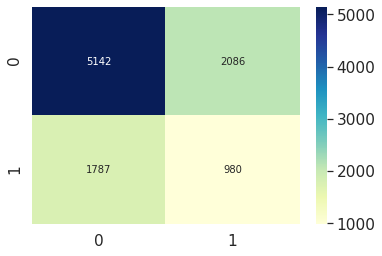

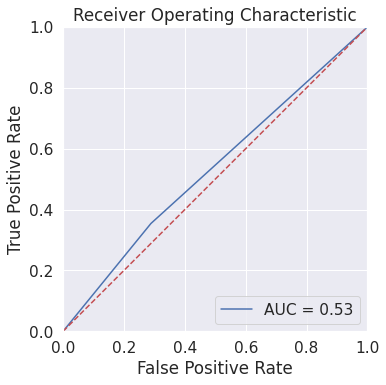

In [23]:
y_pred = (bert_LSTM.predict(reshaped_bert_val) > 0.5).astype("int32")
display_results(y_pred, y_val)